# Data transfer from old to new mesh
This notebook is for transfering the data from the old to the new mesh. It takes as input an old mesh file with data (.vtu), a new mesh file (.msh), and outputs data arrays that can be mapped onto the new mesh in the jax-fem model. There is no need to save the data to the mesh itself, as that is done in the simulation. However, it must be ensured that the data follows the correct cell and point order as the new mesh.

Different types of data require different handling. All use nearest neighbour interpolation for obtaining new values.
* Quad data: 
    * first average quad dat over each cell in old mesh
    * then interpolate from old to new mesh
    * finally redistribute over quads in the new mesh
* Node and cell data: direct nearest neighbour interpolation from old to new grid.

In [1]:
# importing the relevant packages
import pyvista as pv
import scipy.spatial as sp
import meshio
import os
import matplotlib.pyplot as plt
import numpy as onp
import jax.numpy as jnp
import pygmsh as pg
import gmsh as gm

from units_constants import ConversionFactors as uc

**Note:**\
There is one HUGE but here. I noticed that the .npz arrays weren't sorted for density- oooh wait, nvm. They weren't sorted according to the file number, so compression step. The array as is was fine, so there's no issue there for this application, but do keep it in mind when hard-coding which file is being read in. The first two files are in order, though, so this works for `sol_001.vtu`.\
**Still needs to be solved.**

**To-do:**
- [x] cell data: density
- [x] node data: displacement
- [x] quad data: stress, strain

**Debugging - first line of defense**
* do the indices match? 
* is the subset that I need actually being retrieved, and not another or the entire set?
* is stuff that needs to be changed being changed, and stuff that needs to stay put, not?
* plotting, plotting, plotting!

**Bugs**
* order of npz data files doesn't match order of vtu files --> fixed? Im not sure where the issue was but the scatter plot seems to agree with me.
* k-nearest neighbours only works for $k=3$, something about shape broadcasting. --> fixed with chatGPT

## Step 1: Read in current and new mesh, and the data fields
**30/05/2025 status:** all code in place and working, though there are some checks left to run and the order of saving bug in the sim should *really* be fixed.

Let's read in the current and new mesh.\
Required info:
* Cell center coordinates, node coordinates of current and new mesh
* All data (density, stress, strain, displacement) living on current mesh

In [2]:
rho_center = 0.0003*2.65 # density in the center, for file selection
mesh_BEST_18 = f"C:/Users/spaan/Thesis/BEST/sil-density-model-18_80_petsc_solver_{rho_center}_1.0rho_20steps_HEX8/vtk/sol_001.vtu" 
#'C:\Users\spaan\Thesis\BEST\sil-density-model-18_80_petsc_solver_0.0007949999999999999_1.0rho_20steps_HEX8'


mesh_save_test = f"C:/Users/spaan/Thesis/sil-density-model-18_foo_petsc_solver_{rho_center}_1.0rho_20steps_HEX8/vtk/sol_001.vtu"
current_mesh_file = mesh_BEST_18 # current mesh that we strip of data
new_mesh_file = "new_box.msh" # new mesh we want to interpolate data on

current_mesh = pv.read(current_mesh_file)
current_mesh = current_mesh.warp_by_vector('sol', factor = 1) # don't forget to warp it!
new_mesh = pv.read(new_mesh_file)

# separate npz data files
parent_dir_data = f'C:/Users/spaan/Thesis/BEST/sil-density-model-18_80_petsc_solver_{rho_center}_1.0rho_20steps_HEX8/data/'
avg_data_file = parent_dir_data + 'avg-stress-strain-density-mass.npz' # same name for all sims
avg_data = jnp.load(avg_data_file)

# TET mesh test
# 1. Read in mesh, extract surface cells.
# of course this is not going to work because they are fucking hexahedrons! 
mesh_num = '010'
mesh_14 = f"FourteenthSesh_31-03-2025/sil-density-model-14_80_umfpack_solver_0.0007949999999999999_1.0rho_1000cells_80steps/vtk/sol_001.vtu"
mesh_BEST_17 = f"C:/Users/spaan/Thesis/BEST/sil-density-model-17_80_petsc_solver_0.00053_1.0rho_1000cells_20steps_HEX8/vtk/sol_001.vtu"
mesh_10cell_TET4 = f'C:/Users/spaan/Thesis/BEST/TET test/sil-density-model-rebuild_sim1_petsc_solver_20steps_80compr_7.950000e-04dens_TET4/vtk/u_{mesh_num}.vtu'
mesh_20cell_TET4 = f"C:/Users/spaan/Thesis/BEST/TET test/sil-density-model-rebuild_sim10_petsc_solver_20steps_20cells_foocompr_7.950000e-04dens_10densfactor_unifieldtype_TET4/vtk/u_{mesh_num}.vtu"


new_mesh_name = "10cell_TET4_new"

current_mesh_file = mesh_10cell_TET4
file = current_mesh_file

current_mesh = pv.read(current_mesh_file)
current_mesh = current_mesh.warp_by_vector('sol', factor = 1) # don't forget to warp it!

parent_dir_data = file[:-13] + 'data/'
avg_data_file = parent_dir_data + 'avg-stress-strain-density-mass.npz'
avg_data = jnp.load(avg_data_file)
new_mesh_file = new_mesh_name + '.msh'
new_mesh = pv.read(new_mesh_file)
# # old quad data loading
# data_file = parent_dir_data + 'stress-strain-density12.npz' # note: compression step is hard-coded
# data = jnp.load(data_file) # densities on quads, should be the same as the .vtu data
# stress, strain, density_npz = data['stress'], data['strain'], data['density']

# New data loading
data_file_stress = parent_dir_data + 'stress1.npy'
data_file_strain = parent_dir_data + 'strain1.npy'
stress = jnp.load(data_file_stress)
strain = jnp.load(data_file_strain)
cell_stress, cell_strain = jnp.mean(stress, axis = 1), jnp.mean(strain, axis = 1) # cell-averaged stress and strain

# checking the meshes
plot = pv.Plotter(shape=(1, 2), window_size = (1200, 800), image_scale = 3)
plot.subplot(0,0)
plot.add_text("current mesh")
plot.add_mesh(current_mesh, show_edges = True)
plot.subplot(0,1)
plot.add_text("new mesh")
plot.add_mesh(new_mesh, show_edges=True, color  = 'yellow')
plot.screenshot(filename = current_mesh_file[:-14]+f"/mesh-comparison.png")
plot.show()

Widget(value='<iframe src="http://localhost:56038/index.html?ui=P_0x21d4cd8c9e0_0&reconnect=auto" class="pyvis…

In [3]:
plot = pv.Plotter(shape=(1, 2), window_size = (1200, 800), image_scale = 3)
plot.subplot(0,0)
plot.add_text("current mesh")
plot.add_mesh(current_mesh, show_edges = True)
plot.camera_position = 'xz'
plot.subplot(0,1)
plot.add_text("new mesh")
plot.add_mesh(new_mesh, show_edges=True, color  = 'yellow')
plot.camera_position = 'xz'
plot.screenshot(filename = current_mesh_file[:-14]+f"/mesh-comparison.png")
plot.show()

Widget(value='<iframe src="http://localhost:56038/index.html?ui=P_0x21d0afdcd40_1&reconnect=auto" class="pyvis…

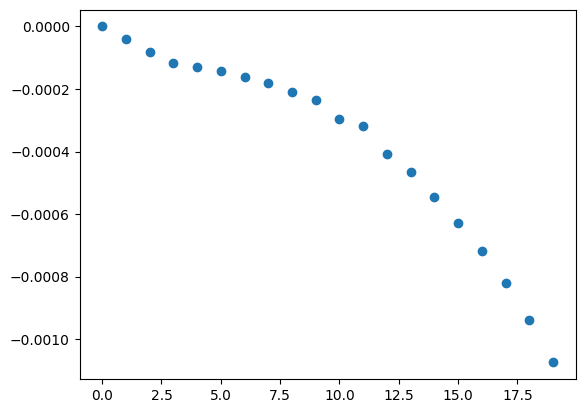

In [4]:
# Checking the stress order
n = 20
zz_stresses = []
for v in range(n):
    stress = jnp.load(parent_dir_data +f'stress{v}.npy')
    zz_stress = stress[0,0,2,2]
    zz_stresses.append(zz_stress)
    #print(stress[0,0,2,2])
plt.scatter(jnp.arange(0,20,1), zz_stresses)

In [5]:
# coordinates (Cartesian) of nodes and cell centers
# IDs match the index number of the array (? check w. PyGmsh, I know it's true for .vtu)
pc_coords = current_mesh.points
cc_coords = current_mesh.cell_centers().points
num_pc_points = current_mesh.n_points
num_cc_cells = current_mesh.n_cells

# extracting ONLY the tetrahedron cells. See the chatGPT convo here on the error: https://chatgpt.com/share/6839f3a6-0424-8007-8d73-4bb8b5564888
VTK_TETRA = 10
tet_indices = new_mesh.celltypes == VTK_TETRA
tet_mesh = new_mesh.extract_cells(tet_indices)
pn_coords = tet_mesh.points
cn_coords = tet_mesh.cell_centers().points
num_pn_points = tet_mesh.n_points
num_cn_cells = tet_mesh.n_cells

print(tet_mesh.n_cells)
print(tet_mesh.n_points)

# mesh data
# I'm using the mesh density, not the npz density, because the latter is too bugged
density_mesh = current_mesh['density (g/cm^3)'] # cell data
density = density_mesh
sol = current_mesh['sol'] # node data
#pv.plot(cc_coords)

2241
697


In [6]:
# """ 
# This stupid cell is a temporary workaround for a massive bug in the simulator where the npz arrays are saved.
# Change this FIRST THING on Monday, beginning with what I wrote in the 30/05/2025 daily note, plus any other fix I 
# can think of. 

# Instructions: find the file with the lowest (ideally zero) difference between the density values and use that.
# Or just use the mesh density because that's already correct :P Yes, do that. 

# """
# # extract numpy arrays
# data_list = []
# stresses = []
# strains = []
# #densities = []
# for subdir, dirs, files in os.walk(parent_dir_data):
#     # if /data/ exists, read in data
#     for file in files:
#         fdir = parent_dir_data + file
#         data_list.append(jnp.load(fdir))

# # volume averaged stress and strain per frame - 3x3 matrices with the ii'th elements the principle stresses and strains
# avg_stress, avg_strain = data_list[0]['avg_stress'], data_list[0]['avg_strain']
# data_list.pop(0)
# stresses = data_list[20:]
# strains = data_list[:20]
# # for some reason this shit is not ordered right. The values are correct, but not the order.
# # the full data arrays for stress, strain, density for each frame, cell, and quad point
# # note: density is cell data, but for calculation purposes it's redistributed over the quads. Each quad in a cell has the same value though.
# for v in range(20):
#     stress = stresses[v]
#     print(stress[0,0,2,2])

# # densities = jnp.array(densities)
# # jnp.sort(densities[:, 0])
# # for density_np in densities:
# #     print((density_mesh[0:10] - density_np[0:10])/density_mesh[0])

### Step 2. Interpolate cell data
* select a cell center in the new mesh
* find nearest k neighbours to that cell center in the current mesh, using those cell centers
* retrieve density at nearest neighbour points
* interpolate density
* save density to a new array which is ordered according to the new mesh cell order

Everything seems in order? Let's see if I can assign it to the new mesh. Or make a histogram of the data.\

IT FUCKING WORKS. HALLELUJAH

**Verdict 30/05/2025**
* Compared min, max values. Seems to be quite alright.

In [7]:
def k_nearest_neighbours(loc, neighbours, k):
    """Returns unordered list of k nearest neighbours to loc. 

    Args:
        loc (float, array-like): coordinates of location from where to look
        neighbours (float, array-like): coords of neighbours of loc
        k (int): number of nearest neighbours to return

    Returns:
        float, array-like: list of neighbours closest to loc
    """
    
    dists = jnp.linalg.norm(neighbours - loc, axis =1)
    k_nearest = jnp.argpartition(dists, k)[:k] # sort only until the first 3 (nearest) positions are filled, and leave the rest unsorted
    return k_nearest, neighbours[k_nearest], dists[k_nearest]

def weighted_mean_scalar(vals, scaler):
    """Calculates the weighted mean of vals using scaler as weights.

    Args:
        vals (float, array-like): array of values to average
        scaler (float, array-like): array of weights. Should be a scalar or 1D vector of length(vals)

    Returns:
        float, array-like: weighted mean of vals
    """

    weights = jnp.array([1/s for s in scaler])
    norm_factor = 1/jnp.sum(weights)
    norm_weights = norm_factor*weights
    weighted_mean = jnp.sum(norm_weights * vals)

    return weighted_mean


closest_cells = []
new_densities = []

for i in range(num_cn_cells):
    # i is the cell index
    cn = cn_coords[i] # cell center coords in new mesh

    # find 3 nearest neighbours and their distances to the cell   
    k_IDxs, Cs, ds = k_nearest_neighbours(cn, cc_coords, 3) # indices of nearest cells, coords, norms
    #print(ds)
    for i, p in enumerate(ds):
        if p == 0:
            print("Zero found! Resetting distance to very close.")
            ds = ds.at[i].set(1e-5) # 1e-4 should be replaced by some percentage of the aggregate dimensions
        else: 
            pass
    #print(ds)

    C1, C2, C3 = Cs[0], Cs[1], Cs[2]
    d1, d2, d3 = ds[0], ds[1], ds[2]
    closest_cells.append((C1, C2, C3))

    # calculate the weighted mean data value for said cell
    closest_rhos = density[k_IDxs]
    new_rho = weighted_mean_scalar(closest_rhos, ds)
    new_densities.append(new_rho)
    
# assign new densities to the new mesh
tet_mesh.cell_data['density (g/cm^3)'] = new_densities

In [8]:
# slices = warped_mesh.slice(normal=[0,1,0])
# pl = pv.Plotter()
# pl.add_text(f"Mesh {num}")
# pl.add_mesh(warped_mesh.outline())
# pl.add_mesh(slices, scalars = scalar, show_edges = True, cmap = 'magma_r') # keep in mind that these values have been scaled by 500
# pl.show_axes()
# #pl.add_floor(pad=1.0, color = 'silver')
# pl.show()

current_slice = current_mesh.slice(normal = [0,1,0])
tet_slice = tet_mesh.slice(normal = [0,1,0])

scalar_name = 'density'
# checking the meshes
plot = pv.Plotter(shape=(1, 2),  window_size = (1200, 800), image_scale = 3)
plot.subplot(0,0)
plot.add_mesh(current_mesh.outline())
plot.add_text("current mesh")
plot.camera_position = 'xz'
plot.add_mesh(current_slice, show_edges = True, scalars = 'density (g/cm^3)', cmap = 'magma_r')
plot.subplot(0,1)
plot.add_text("new mesh")
plot.add_mesh(tet_mesh.outline())
plot.add_mesh(tet_slice, show_edges=True, scalars = 'density (g/cm^3)', cmap = 'magma_r')
plot.camera_position = 'xz'
plot.screenshot(filename = current_mesh_file[:-14]+f"/mesh-comparison_{scalar_name}.png")
plot.show()



#pv.plot(tet_mesh, scalars = 'density')

Widget(value='<iframe src="http://localhost:56038/index.html?ui=P_0x21d76d998e0_2&reconnect=auto" class="pyvis…

In [30]:
masses = []
x_deform = []
y_deform = []
volumes = []

meshes_to_check = [current_mesh, tet_mesh]
rho_vals = [current_mesh['density (g/cm^3)'], tet_mesh['density (g/cm^3)']]
#print(rho_vals[0])

for i, cm in enumerate(meshes_to_check):
    # mass calc
    cell_sizes = cm.compute_cell_sizes()
    cell_volumes = cell_sizes['Volume']
    total_volume = onp.sum(cell_volumes)
    volumes.append(total_volume)
    agg_mass = onp.sum(cell_volumes*rho_vals[i])
    masses.append(agg_mass)

volumes = onp.array(volumes)
masses = onp.array(masses)

# x_deform = np.array(x_deform)
# y_deform = np.array(y_deform)
# x_deform

mass_losses = []
for m in range(len(masses)-1):
    #print(f"Relative mass loss: {(masses[m+1]/masses[m]*100) - 100:.2e} %")
    mass_losses.append((masses[m+1] -masses[m]))
print(f"Total mass loss: {onp.sum(mass_losses)} g")
print(f"Total relative mass loss: {(onp.sum(mass_losses)/masses[0] * 100)} %")

# mass_fig = plt.figure(dpi=300, figsize = (8, 6))
# massax = mass_fig.subplots(1,1)
# mass_fig.suptitle("Aggreggate volume vs rho")
# massax.scatter(avg_rho[1:], volumes[:-1])
# massax.set_xlabel(r'$\rho$ (g/cm$^3$)')
# massax.set_ylabel(r'$V$ (cm$^3$)')
# plt.tight_layout()
# mass_fig.savefig(f"{fig_dir}/mass-conservation-check_rho-vol.png")
# plt.show()
print(current_mesh.n_cells, current_mesh.n_points)
print(tet_mesh.n_cells, tet_mesh.n_points)

Total mass loss: 7.40947117877722e-05 g
Total relative mass loss: 5.050116344677521 %
6000 1331
2241 697


### Step 3. Interpolate node data
Sol = displacement
* select a node in the new mesh
* find nearest k neighbours to that node in the current mesh, using those nodes
* retrieve displacement at nearest neighbour points
* interpolate displacement
* save displacement to a new array which is ordered according to the new mesh node order

I THINK THIS ALSO FUCKING WORKS.

**Verdict 30/05/2025**\
The result is not optimal, as there is quite a bit of smoothing going on (see the minimum and maximum displacement values). But I suppose for a first result, it's quite okay. I'm also not totally sure why there's not such an intense gradient as for the current mesh.

There's probably also something to be said for only selecting nearest neighbours within a certain z-range around the node, rather than using the radial distance. Since the displacement is happening primarily in the z-direction adn all.

*01/06/2025 Update:* Well I'll be damned, it's fixed. Turns out the $k$-nearest neighbour bug was the reason the results looked so weird, because I was not reshaping the weights correctly.
Because I already used chatGPT to fix the matrix function it worked fine there, and the scalar function doesn't need reshaping. So now it all works out.

In [10]:
def weighted_mean_vector(vals, scaler):
    """Calculates the weighted mean of vals using scaler as weights.

    Args:
        vals (float, array-like): array of values to average
        scaler (float, array-like): array of weights. Should be a scalar or 1D vector of length(vals)

    Returns:
        float, array-like: weighted mean of vals
    """
    # my code
    # weights = 1/jnp.array(scaler)
    # norm_factor = 1/jnp.sum(weights)
    # norm_weights = norm_factor*weights
    # weighted_mean = jnp.sum(norm_weights * vals, axis = 1)
    #print(jnp.any(jnp.array(scaler) == 0))  # Will be True if there are zeroes --> no True, no zeros

    # chatGPT fix, because the successful run for k = 3 was a happy little accident as they say. 
    weights = 1 / jnp.array(scaler)

    if True in jnp.isnan(weights):
        print("Nan!")
    
    if True in jnp.isinf(weights):
        print("Inf!")


    if jnp.sum(weights) == 0:
        print("Found zero")

    #print(weights)
    #print(jnp.isnan(weights), jnp.isinf(weights))
    norm_weights = (weights / jnp.sum(weights)).reshape(-1, 1)  # Shape (k, 1)
    weighted_mean = jnp.sum(norm_weights * vals, axis=0)        # Sum over k

    return weighted_mean

closest_nodes = []
new_sols = []

# len(pn_coords)

# DEBUG --------------------------------------

for j in range(num_pn_points):
    # i is the cell index
    pn = pn_coords[j] # cell center coords in new mesh

    # find 3 nearest neighbours and their distances to the cell   
    k_IDxs, Ps, ds = k_nearest_neighbours(pn, pc_coords,4) # indices of nearest cells, coords, norms
    closest_nodes.append(Ps)
    #print(ds)
    for i, p in enumerate(ds):
        if p == 0:
            print("Zero found! Resetting distance to very close.")
            ds = ds.at[i].set(1e-5) # 1e-4 should be replaced by some percentage of the aggregate dimensions
        else: 
            pass
    #print(ds)
    # calculate the weighted mean data value for said cell
    closest_sols = sol[k_IDxs]
    if True in onp.isnan(closest_sols):
        print("NaN found!")
    new_sol = weighted_mean_vector(closest_sols, ds)
    new_sols.append(new_sol)

Zero found! Resetting distance to very close.


In [11]:
# printing min and max norms for the old and new solutions, for comparison
sol_norm = onp.linalg.norm(sol, axis = 1)
new_sol_norm = onp.linalg.norm(new_sols, axis = 1)
print(min(sol_norm))
print(min(new_sol_norm))
print(max(sol_norm))
print(max(new_sol_norm))
# print(f"Min and max sol of current mesh: {jnp.min(onp.linalg.norm(sol), axis = 1)}, {jnp.max(onp.linalg.norm(sol), axis = 1)}")
# print(f"Min and max sol of new mesh: {jnp.min(onp.linalg.norm(new_sol), axis = 1)}, {jnp.max(onp.linalg.norm(new_sol), axis = 1)}")
tet_mesh.point_data['sol new'] = new_sols

if True in onp.isnan(new_sols):
    print("NaN found!")


0.0
2.5417305e-05
0.40255204
0.39196283


In [27]:
mean_old = onp.mean(current_mesh['sol'])
mean_new = onp.mean(tet_mesh['sol new'])
print(f"Relative difference in mean value (new - old)/old: ", (mean_new-mean_old)/mean_old * 100, '%')

Relative difference in mean value (new - old)/old:  2.6988196 %


In [12]:
current_slice = current_mesh.slice(normal = [0,1,0])
tet_slice = tet_mesh.slice(normal = [0,1,0])

scalar_name = 'sol-new'
# checking the meshes
plot2 = pv.Plotter(shape=(1, 2),  window_size = (1200, 800), image_scale = 3)
plot2.subplot(0,0)
plot2.add_text("current mesh")
plot2.add_mesh(current_slice, show_edges = True, scalars = 'sol', cmap = 'viridis')
plot2.camera_position = 'xz'
plot2.subplot(0,1)
plot2.add_text("new mesh")
plot2.add_mesh(tet_slice, show_edges=True, scalars = 'sol new', cmap = 'viridis')
plot2.camera_position = 'xz'
plot2.screenshot(filename = current_mesh_file[:-14]+f"/mesh-comparison_{scalar_name}.png")
plot2.show()


Widget(value='<iframe src="http://localhost:56038/index.html?ui=P_0x21d85950080_3&reconnect=auto" class="pyvis…

### Step 4. Interpolate quad data
Same as cell data, as we have reshaped the quad into cell data up above.
* select a cell in the new mesh
* find nearest k neighbours to that cell in the current mesh, using those cells
* retrieve displacement at nearest neighbour cell centers
* interpolate displacement
* save displacement to a new array which is ordered according to the new mesh cell order

*Happy dance*


In [17]:
def weighted_mean_vector_upd(vals, scaler):
    """
    Calculates the weighted mean of a set of 3x3 arrays using scaler as inverse weights.
    Modified for (Nx3x3) input vals with N the number of value points to average.

    Args:
        vals (array-like): array of shape (N, 3, 3), values to average
        scaler (array-like): array of shape (N,), weights to be inverted and normalized

    Returns:
        array-like: weighted mean 3x3 array
    """
    weights = 1/jnp.array(scaler)  
    norm_weights = weights / jnp.sum(weights)  # normalize to sum to 1

    # Reshape weights for broadcasting over (N, 3, 3)
    norm_weights = norm_weights[:, None, None]  # shape: (N, 1, 1)
    weighted_mean = jnp.sum(norm_weights * vals, axis=0)  # shape: (3, 3)

    return weighted_mean

closest_cells_quad_data = []
new_stresses = []
new_strains = []
num_quads = len(stress[0])
print(num_quads)

# len(cn_coords)
for i in range(num_cn_cells):
    # i is the cell index
    cn = cn_coords[i] # cell center coords in new mesh

    # find 3 nearest neighbours and their distances to the cell   
    k_IDxs, Cs, ds = k_nearest_neighbours(cn, cc_coords, 4) # indices of nearest cells, coords, norms
    closest_cells_quad_data.append((C1, C2, C3))
    #print(ds)
    for i, p in enumerate(ds):
        if p == 0:
            print("Zero found! Resetting distance to very close.")
            ds = ds.at[i].set(1e-5) # 1e-4 should be replaced by some percentage of the aggregate dimensions
        else: 
            pass
    #print(ds)

    # calculate the weighted mean data value for said cell and reshape
    # stress
    closest_sigmas = cell_stress[k_IDxs]
    new_sigmas = weighted_mean_vector_upd(closest_sigmas, ds)
    new_sigmas_quads = jnp.repeat(new_sigmas[None, :, :], repeats = num_quads, axis = 0)
    new_stresses.append(new_sigmas_quads)

    # strain
    closest_epsilons = cell_strain[k_IDxs]
    new_epsilons = weighted_mean_vector_upd(closest_epsilons, ds)
    new_epsilons_quads = jnp.repeat(new_epsilons[None, :, :], repeats = num_quads, axis = 0)
    new_strains.append(new_epsilons_quads)


1


Oh my goodness I can't believe it, but I think everything works. Maybe not to the best of its abilities, but it works. I only haven't checked the data for the interpolated stresses and strains yet, but the shapes are correct so I suppose that's a start. 

Possible checks:
* plot old and new stress, strain to compare values. I hope it doesn't give the same massive smoothing as the displacement.

In [18]:
current_mesh['stress'] = cell_stress
current_mesh['strain'] = cell_strain
tet_mesh['stress new'] = jnp.mean(jnp.array(new_stresses), axis = 1)
tet_mesh['strain new'] = jnp.mean(jnp.array(new_strains), axis = 1)

In [28]:
mean_old_sig = onp.mean(current_mesh['stress'])
mean_old_eps = onp.mean(current_mesh['strain'])
mean_new_sig = onp.mean(tet_mesh['stress new'])
mean_new_eps = onp.mean(tet_mesh['strain new'])
print(f"Relative difference in mean value stress (new - old)/old: ", (mean_new_sig-mean_old_sig)/mean_old_sig* 100, '%')
print(f"Relative difference in mean value strain (new - old)/old: ", (mean_new_eps-mean_old_eps)/mean_old_eps* 100, '%')

Relative difference in mean value stress (new - old)/old:  -10.263983 %
Relative difference in mean value strain (new - old)/old:  3.8120012 %


In [20]:


# plot3 = pv.Plotter(shape=(1, 2), image_scale=3)
# plot3.subplot(0,0)
# plot3.add_text("current mesh")
# plot3.add_mesh(current_mesh, show_edges = False, scalars = 'strain', cmap = 'viridis')
# plot3.subplot(0,1)
# plot3.add_text("new mesh")
# plot3.add_mesh(tet_mesh, show_edges=False, scalars = 'strain new', cmap = 'viridis')
# plot3.screenshot(filename = parent_dir_data[:-5]+"/remesh-strain.png")
# plot3.show()

current_slice = current_mesh.slice(normal = [0,1,0])
tet_slice = tet_mesh.slice(normal = [0,1,0])

scalar_name = 'strain'
# checking the meshes
plot3 = pv.Plotter(shape=(1, 2),  window_size = (1200, 800), image_scale = 3)
plot3.subplot(0,0)
plot3.add_text("current mesh")
plot3.add_mesh(current_mesh, show_edges = True, scalars = 'strain', cmap = 'viridis')
plot3.subplot(0,1)
plot3.add_text("new mesh")
plot3.add_mesh(tet_mesh, show_edges=True, scalars = 'strain new', cmap = 'viridis')
plot3.screenshot(filename = current_mesh_file[:-14]+f"/mesh-comparison_{scalar_name}_3D.png")
plot3.show()

Widget(value='<iframe src="http://localhost:56038/index.html?ui=P_0x21d85979e80_4&reconnect=auto" class="pyvis…

In [21]:
plot3 = pv.Plotter(shape=(1, 2),  window_size = (1200, 800), image_scale = 3)
plot3.subplot(0,0)
plot3.add_text("current mesh")
plot3.camera_position = 'xz'
plot3.add_mesh(current_slice, show_edges = True, scalars = 'strain', cmap = 'viridis')
plot3.subplot(0,1)
plot3.add_text("new mesh")
plot3.add_mesh(tet_slice, show_edges=True, scalars = 'strain new', cmap = 'viridis')
plot3.camera_position = 'xz'
plot3.screenshot(filename = current_mesh_file[:-14]+f"/mesh-comparison_{scalar_name}.png")
plot3.show()

Widget(value='<iframe src="http://localhost:56038/index.html?ui=P_0x21d76ce1a30_5&reconnect=auto" class="pyvis…

In [22]:
plot3 = pv.Plotter(shape=(1, 2),  window_size = (1200, 800), image_scale = 3)
plot3.subplot(0,0)
plot3.add_text("current mesh")
plot3.camera_position = 'xz'
plot3.add_mesh(current_mesh, show_edges = True, scalars = 'strain', cmap = 'viridis')
plot3.subplot(0,1)
plot3.add_text("new mesh")
plot3.add_mesh(tet_mesh, show_edges=True, scalars = 'strain new', cmap = 'viridis')
plot3.camera_position = 'xz'
plot3.screenshot(filename = current_mesh_file[:-14]+f"/mesh-comparison_{scalar_name}_outside.png")
plot3.show()

Widget(value='<iframe src="http://localhost:56038/index.html?ui=P_0x21d8a323770_6&reconnect=auto" class="pyvis…

In [23]:
scalar = 'stress'

plot4 = pv.Plotter(shape=(1, 2),  window_size = (1200, 800), image_scale = 3)
plot4.subplot(0,0)
plot4.add_text("current mesh")
plot4.add_mesh(current_mesh, show_edges = True, scalars = 'stress', cmap = 'viridis')
plot4.subplot(0,1)
plot4.add_text("new mesh")
plot4.add_mesh(tet_mesh, show_edges=True, scalars = 'stress new', cmap = 'viridis')
plot4.screenshot(filename = current_mesh_file[:-14]+f"/mesh-comparison_{scalar_name}_3D.png")
plot4.show()

Widget(value='<iframe src="http://localhost:56038/index.html?ui=P_0x21d859a35c0_7&reconnect=auto" class="pyvis…

In [24]:
current_slice = current_mesh.slice(normal = [0,0,1])
tet_slice = tet_mesh.slice(normal = [0,0,1])

plot4 = pv.Plotter(shape=(1, 2),  window_size = (1200, 800), image_scale = 3)
plot4.subplot(0,0)
plot4.add_text("current mesh")
plot4.camera_position = 'xy'
plot4.add_mesh(current_slice, show_edges = True, scalars = 'stress', cmap = 'viridis')
plot4.subplot(0,1)
plot4.add_text("new mesh")
plot4.add_mesh(tet_slice, show_edges=True, scalars = 'stress new', cmap = 'viridis')
plot4.camera_position = 'xy'
plot4.screenshot(filename = current_mesh_file[:-14]+f"/mesh-comparison_{scalar_name}.png")
plot4.show()

Widget(value='<iframe src="http://localhost:56038/index.html?ui=P_0x21d8a35c230_8&reconnect=auto" class="pyvis…

In [25]:

plot4 = pv.Plotter(shape=(1, 2),  window_size = (1200, 800), image_scale = 3)
plot4.subplot(0,0)
plot4.add_text("current mesh")
plot4.camera_position = 'xz'
plot4.add_mesh(current_mesh, show_edges = True, scalars = 'stress', cmap = 'viridis')
plot4.subplot(0,1)
plot4.add_text("new mesh")
plot4.add_mesh(tet_mesh, show_edges=True, scalars = 'stress new', cmap = 'viridis')
plot4.camera_position = 'xz'
plot4.screenshot(filename = current_mesh_file[:-14]+f"/mesh-comparison_{scalar_name}_outside.png")
plot4.show()

Widget(value='<iframe src="http://localhost:56038/index.html?ui=P_0x21d8a35cce0_9&reconnect=auto" class="pyvis…

In [26]:
masses = []
x_deform = []
y_deform = []

for i, wm in enumerate(warped_meshes):
    # mass calc
    cell_sizes = wm.compute_cell_sizes()
    cell_volumes = cell_sizes['Volume']
    agg_mass = np.sum(cell_volumes*rho_vals[i, :])
    masses.append(agg_mass)

    # # xy deform calcs
    # bounds = wm.bounds
    # x_norm_init, y_norm_init = np.abs(init_bounds[1] - init_bounds[0]), np.abs(init_bounds[3] - init_bounds[2]) 
    # x_norm = np.abs(bounds[1] - bounds[0])
    # y_norm = np.abs(bounds[3] - bounds[2])
    # x_change = (x_norm - x_norm_init)/x_norm_init
    # y_change = (y_norm - y_norm_init)/y_norm_init
    # x_deform.append(x_change)
    # y_deform.append(y_change)


masses = np.array(masses)
masses
# x_deform = np.array(x_deform)
# y_deform = np.array(y_deform)
# x_deform

NameError: name 'warped_meshes' is not defined